In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [85]:
TC = pd.read_csv("/Users/rahulkumar/Desktop/telecom_churn_data.csv")

In [35]:
print(TC.head())

   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...     

In [11]:
print(TC.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None


In [13]:
print(TC.describe())

       mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.5

In [15]:
print(TC.isnull().sum())  # Check for missing values

mobile_number        0
circle_id            0
loc_og_t2o_mou    1018
std_og_t2o_mou    1018
loc_ic_t2o_mou    1018
                  ... 
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
sep_vbc_3g           0
Length: 226, dtype: int64


In [25]:
TC.shape

(99999, 226)

In [31]:
def missing_values_analysis(TC):
    missing_percentage = TC.isnull().sum() / len(TC) * 100
    missing_TC = pd.DataFrame({'Feature': TC.columns, 'Missing Percentage': missing_percentage})
    print(missing_TC[missing_TC['Missing Percentage'] > 0].sort_values(by='Missing Percentage', ascending=False))
    return missing_TC

missing_values_analysis(TC)

# Filling Missing Values
for col in TC.columns:
    if TC[col].dtype == 'object':
        TC.loc[:, col] = TC[col].fillna(TC[col].mode()[0]) # Fill categorical with mode
    else:
        TC.loc[:, col] = TC[col].fillna(TC[col].median())  

Empty DataFrame
Columns: [Feature, Missing Percentage]
Index: []


In [41]:
# Filtering high-value customers
X_thresh = TC[['total_rech_amt_6', 'total_rech_amt_7']].mean().quantile(0.7)
TC_high_value = TC[(TC['total_rech_amt_6'] >= X_thresh) & (TC['total_rech_amt_7'] >= X_thresh)]

In [51]:
TC_high_value.shape

(24298, 227)

In [47]:
TC_high_value.loc[:, 'churn'] = ((TC_high_value['total_ic_mou_9'] == 0) &
                                 (TC_high_value['total_og_mou_9'] == 0) &
                                 (TC_high_value['vol_2g_mb_9'] == 0) &
                                 (TC_high_value['vol_3g_mb_9'] == 0)).astype(int)

In [55]:
# Dropping churn-month features
drop_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
TC_high_value = TC_high_value.loc[:, ~TC_high_value.columns.isin(drop_cols)]



In [59]:
X = TC_high_value.drop(columns=['churn'])
y = TC_high_value['churn']

In [63]:
# Selecting only numerical columns for scaling
numerical_cols = X.select_dtypes(include=['number']).columns
X_num = X[numerical_cols]

In [65]:
# Scaling the numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

In [67]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [69]:

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [71]:
# Logistic Regression with Regularization
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l2', C=1.0, class_weight='balanced'))
])
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9532921810699588
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4528
           1       0.60      0.98      0.74       332

    accuracy                           0.95      4860
   macro avg       0.80      0.97      0.86      4860
weighted avg       0.97      0.95      0.96      4860



In [73]:
# Decision Tree Classifier
dec_tree = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
dec_tree.fit(X_train, y_train)
y_pred_tree = dec_tree.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.9045267489711935
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      4528
           1       0.40      0.78      0.53       332

    accuracy                           0.90      4860
   macro avg       0.69      0.85      0.74      4860
weighted avg       0.94      0.90      0.92      4860



In [75]:
# Random Forest Classifier with Hyperparameter Tuning
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9415637860082304
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4528
           1       0.56      0.67      0.61       332

    accuracy                           0.94      4860
   macro avg       0.77      0.82      0.79      4860
weighted avg       0.95      0.94      0.94      4860



In [79]:
# AdaBoost Classifier with Base Estimator as Decision Tree (Updated Syntax for sklearn 1.2+)
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.9504115226337448
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4528
           1       0.68      0.51      0.59       332

    accuracy                           0.95      4860
   macro avg       0.82      0.75      0.78      4860
weighted avg       0.95      0.95      0.95      4860



In [89]:
# Convert scaled array back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)

# Perform RFE with Logistic Regression
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(X_scaled_df, y)

# Ensure selected features are correctly indexed
selected_features = X_scaled_df.columns[rfe.support_]
print("Selected Features using RFE:", selected_features)

# Transform dataset to retain selected features only
X_rfe = X_scaled_df[selected_features].values


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Selected Features using RFE: Index(['loc_og_t2f_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'spl_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'spl_ic_mou_9'],
      dtype='object')


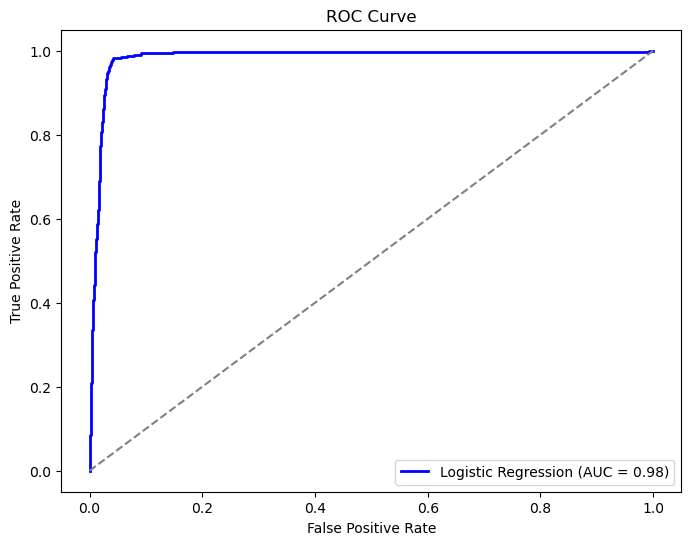

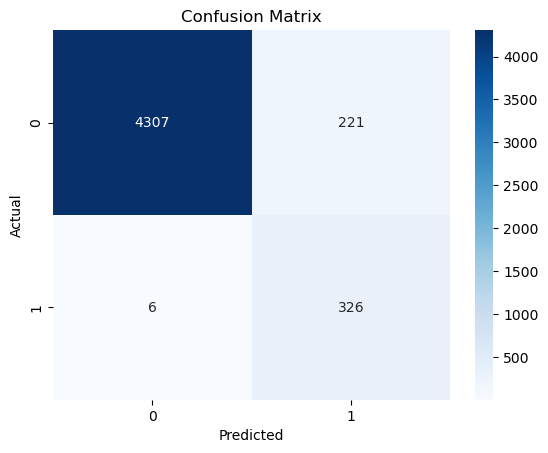

In [91]:
# ROC Curve and AUC for Logistic Regression
y_prob_log = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_log)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [95]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(f"{model_name} Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
evaluate_model(log_reg, X_test, y_test, "Logistic Regression")


Logistic Regression Accuracy: 0.9532921810699588
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4528
           1       0.60      0.98      0.74       332

    accuracy                           0.95      4860
   macro avg       0.80      0.97      0.86      4860
weighted avg       0.97      0.95      0.96      4860

